# CausalImpact Analysis

https://github.com/WillianFuks/tfcausalimpact

In [ ]:
# !conda create --name causal_env python=3.9
# !conda activate causal_env
# !conda install tensorflow=2.15
# !pip install tensorflow_probability==0.22
# !pip install tfcausalimpact==0.0.12
# !pip install numpy==1.23.5
# !pip install tslearn==0.6.3
# !conda install ipykernel
# !python -m ipykernel install --user --name causal_env

In [2]:
import pandas as pd
import numpy as np
import os
from time import strptime

from causalimpact import CausalImpact

from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.utils import to_time_series_dataset

import warnings
warnings.filterwarnings('ignore')

2023-12-16 17:31:45.980540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/sam/opt/anaconda3/envs/causal_env/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# Getting the BLS Data Together

In [160]:
bls_df = pd.DataFrame()

# Specify the folder path where your Excel files are located
folder_path = "./Data"

# Iterate through files in the folder
for filename in os.listdir(folder_path):
    # Check if the file starts with "Unemployment" and has a .xlsx extension
    if filename.startswith("SeriesReport") and filename.endswith(".xlsx"):
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)

        # Read the county name
        county = pd.read_excel(file_path).loc[4, 'Unnamed: 1']

        # Read the Excel file into a pandas DataFrame
        temp_df = pd.read_excel(file_path, header=10)
        temp_df['County'] = county
        
        # Now you can work with the DataFrame (df) for further analysis or processing
        print(f"Read data from file: {file_path}")
        
        # Example: Display the first few rows of the DataFrame
        bls_df = pd.concat([bls_df, temp_df])

Read data from file: ./Data/SeriesReport-20231216124015_f3e9d2.xlsx
Read data from file: ./Data/SeriesReport-20231216124946_c178f5.xlsx
Read data from file: ./Data/SeriesReport-20231216123837_2f30cc.xlsx
Read data from file: ./Data/SeriesReport-20231216123848_988cf7.xlsx
Read data from file: ./Data/SeriesReport-20231216124941_da42cc.xlsx
Read data from file: ./Data/SeriesReport-20231216124753_7413d4.xlsx
Read data from file: ./Data/SeriesReport-20231216124047_75d5fb.xlsx
Read data from file: ./Data/SeriesReport-20231216124052_27a093.xlsx
Read data from file: ./Data/SeriesReport-20231216123826_9eaa33.xlsx
Read data from file: ./Data/SeriesReport-20231216124545_c55dbe.xlsx
Read data from file: ./Data/SeriesReport-20231216124213_76570f.xlsx
Read data from file: ./Data/SeriesReport-20231216123924_a8def8.xlsx
Read data from file: ./Data/SeriesReport-20231216125018_a883dc.xlsx
Read data from file: ./Data/SeriesReport-20231216124905_d5b40e.xlsx
Read data from file: ./Data/SeriesReport-2023121

In [4]:
# bls_df.to_csv('./Data/Maui_Wildfire_Unemployment.csv')
bls_df = pd.read_csv('./Data/Maui_Wildfire_Unemployment.csv').drop('Unnamed: 0', axis=1, inplace=False)
bls_df

,Year,Period,labor force,employment,unemployment,unemployment rate,County
0,2013,Jan,28744,24807,3937,13.7,"San Benito County, CA"
1,2013,Feb,28925,25117,3808,13.2,"San Benito County, CA"
2,2013,Mar,28873,25204,3669,12.7,"San Benito County, CA"
3,2013,Apr,28738,25386,3352,11.7,"San Benito County, CA"
4,2013,May,28604,25379,3225,11.3,"San Benito County, CA"
...,...,...,...,...,...,...,...
16765,2023,Jun,5823,5609,214,3.7,"Dixie County, FL"
16766,2023,Jul,5836,5612,224,3.8,"Dixie County, FL"
16767,2023,Aug,5990,5754,236,3.9,"Dixie County, FL"
16768,2023,Sep,6180,5914,266,4.3,"Dixie County, FL"


In [5]:
bls_df['County'].nunique()

129

# The Effect of the Maui Wildfire on the Unemployment Rate

In [6]:
bls_df['Period'] = [strptime(str(x), '%b').tm_mon for x in bls_df['Period']]
bls_df['Day'] = '1'
bls_df['Year'] = bls_df['Year'].astype(str)
bls_df['Period'] = bls_df['Period'].apply(lambda x: str(x).zfill(2))
bls_df['Day'] = bls_df['Day'].apply(lambda x: str(x).zfill(2))
bls_df['Date'] = bls_df['Year'] + bls_df['Period'] + bls_df['Day']
bls_df['Date'] = pd.to_datetime(bls_df['Date'])
bls_df.drop(['Day','Period', 'Year'], axis=1, inplace =True)
bls_df

,labor force,employment,unemployment,unemployment rate,County,Date
0,28744,24807,3937,13.7,"San Benito County, CA",2013-01-01
1,28925,25117,3808,13.2,"San Benito County, CA",2013-02-01
2,28873,25204,3669,12.7,"San Benito County, CA",2013-03-01
3,28738,25386,3352,11.7,"San Benito County, CA",2013-04-01
4,28604,25379,3225,11.3,"San Benito County, CA",2013-05-01
...,...,...,...,...,...,...
16765,5823,5609,214,3.7,"Dixie County, FL",2023-06-01
16766,5836,5612,224,3.8,"Dixie County, FL",2023-07-01
16767,5990,5754,236,3.9,"Dixie County, FL",2023-08-01
16768,6180,5914,266,4.3,"Dixie County, FL",2023-09-01


In [7]:
intervention_date = '2023-08-01'

pre_period_start = min(bls_df['Date'])
pre_period_stop = max(bls_df[bls_df['Date'] < intervention_date]['Date'])

post_period_start = min(bls_df[bls_df['Date'] >= intervention_date]['Date'])
post_period_stop = max(bls_df['Date'])

pre_period=[pre_period_start, pre_period_stop]
post_period=[post_period_start, post_period_stop]

### Market Matching

In [8]:
n_neighbors = 30

ts_df = bls_df.copy()
ts_df = ts_df[['Date', 'County', 'unemployment rate']]

# Subset to only the pre intervention period
ts_df = ts_df[ts_df['Date'] < post_period_start]
ts_df.drop('Date', axis=1, inplace=True)

# Subset the pilot
ts_pilot = ts_df[ts_df['County'] == 'Maui County, HI']

# Subset the controls
ts_control = ts_df[ts_df['County'] != 'Maui County, HI']

X_train = to_time_series_dataset([ts_control[ts_control['County'] == c]['unemployment rate'] for c in ts_control['County'].unique().tolist()])
scaler = TimeSeriesScalerMinMax(value_range = (0.0 , 1.0))
X_train_scaled = scaler.fit_transform(X_train)

X_test = to_time_series_dataset([ts_pilot[ts_pilot['County'] == c]['unemployment rate'] for c in ts_pilot['County'].unique().tolist()])
scaler = TimeSeriesScalerMinMax(value_range = (0.0 , 1.0))
X_test_scaled = scaler.fit_transform(X_test)

# nearest neighbor search
knn = KNeighborsTimeSeries(n_neighbors = n_neighbors, metric = 'dtw', n_jobs = -1)
knn.fit(X_train_scaled)

neighbors_list = []

dists, idx = knn.kneighbors(X_test_scaled)

idx = idx.tolist()[0]

control_list = ts_control['County'].unique().tolist()

match_list = [control_list[i] for i in idx]

match_list



['Kauai County, HI',
 'Honolulu County/city, HI',
 'Monroe County, FL',
 'Hawaii County, HI',
 'Mono County, CA',
 'Osceola County, FL',
 'Orange County, FL',
 'Napa County, CA',
 'San Francisco County/city, CA',
 'Marin County, CA',
 'Orange County, CA',
 'Lake County, FL',
 'San Mateo County, CA',
 'Broward County, FL',
 'Sonoma County, CA',
 'San Luis Obispo County, CA',
 'Alpine County, CA',
 'Alameda County, CA',
 'San Diego County, CA',
 'Los Angeles County, CA',
 'Contra Costa County, CA',
 'Walton County, FL',
 'Nevada County, CA',
 'Okaloosa County, FL',
 'Santa Clara County, CA',
 'Polk County, FL',
 'Seminole County, FL',
 'Humboldt County, CA',
 'Ventura County, CA',
 'Santa Barbara County, CA']

In [9]:
dists

array([[0.13926487, 0.23831431, 0.44387124, 0.47718001, 0.49671171,
        0.52934056, 0.61116381, 0.83316631, 0.87717003, 0.87937071,
        0.92547014, 0.96607225, 1.01007888, 1.01016033, 1.06406844,
        1.06956141, 1.1022499 , 1.1460978 , 1.17078436, 1.17948713,
        1.19527067, 1.28351029, 1.31375045, 1.31548838, 1.33162904,
        1.34671602, 1.35303248, 1.37683582, 1.40137745, 1.41925468]])

### Stack the Counties

In [10]:
df = pd.DataFrame()

county_list = bls_df['County'].unique().tolist()
counter = 0
for county in county_list:

    if (county == 'Maui County, HI') or (county in match_list):

        temp_df = bls_df[bls_df['County']==county].rename(columns = {'unemployment rate':county})[['Date', county]]

        if counter != 0:
            df = pd.merge(df, temp_df, how = 'outer', on = ['Date'])
        else:
            df = temp_df.copy()
            counter += 1

In [11]:
column_to_move = df.pop("Maui County, HI")
df.insert(1, "Maui County, HI", column_to_move)
df

,Date,"Maui County, HI","Marin County, CA","San Mateo County, CA","Santa Barbara County, CA","Napa County, CA","Honolulu County/city, HI","Alpine County, CA","Nevada County, CA","Alameda County, CA",...,"Orange County, CA","Contra Costa County, CA","Santa Clara County, CA","Hawaii County, HI","Orange County, FL","San Luis Obispo County, CA","Sonoma County, CA","Kauai County, HI","Seminole County, FL","Ventura County, CA"
0,2013-01-01,5.4,6.0,6.1,9.0,9.0,4.8,9.0,9.4,8.4,...,7.5,8.7,7.5,7.0,8.2,8.0,8.6,6.0,8.1,9.1
1,2013-02-01,5.2,5.6,5.7,8.4,8.0,4.4,8.4,9.1,7.9,...,7.1,8.2,7.1,6.7,7.6,7.4,8.1,5.8,7.5,8.4
2,2013-03-01,5.0,5.4,5.5,7.9,7.7,4.2,8.4,8.9,7.7,...,6.9,8.0,6.9,6.4,7.2,7.1,7.8,5.4,7.1,8.0
3,2013-04-01,4.7,4.9,5.1,6.8,6.9,4.0,10.1,8.3,7.1,...,6.3,7.3,6.4,6.3,7.0,6.6,7.1,5.3,6.8,7.4
4,2013-05-01,4.7,4.9,5.1,6.5,6.4,4.1,10.7,8.2,7.1,...,6.4,7.3,6.3,6.4,7.0,6.5,6.9,5.1,6.9,7.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2023-06-01,3.1,3.4,3.1,3.8,3.5,3.3,7.1,4.0,4.2,...,3.7,4.2,3.7,3.8,2.9,3.5,3.7,3.1,2.8,4.2
126,2023-07-01,2.5,3.3,3.0,3.5,3.3,2.6,7.0,3.9,4.2,...,3.6,4.2,3.6,3.2,3.0,3.3,3.7,2.4,3.0,4.2
127,2023-08-01,4.5,3.7,3.3,3.9,3.6,2.8,7.3,4.2,4.5,...,3.9,4.5,3.9,3.1,3.1,3.7,3.8,2.6,3.0,4.7
128,2023-09-01,8.3,3.5,3.2,3.6,3.5,2.6,6.2,4.0,4.3,...,3.7,4.2,3.7,2.8,3.0,3.5,3.6,2.4,2.9,4.4


In [12]:
df.isna().sum().sum()

0

### CausalImact

In [13]:
df = df.set_index('Date')

In [14]:
ci = CausalImpact(df, pre_period=pre_period, post_period=post_period)

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


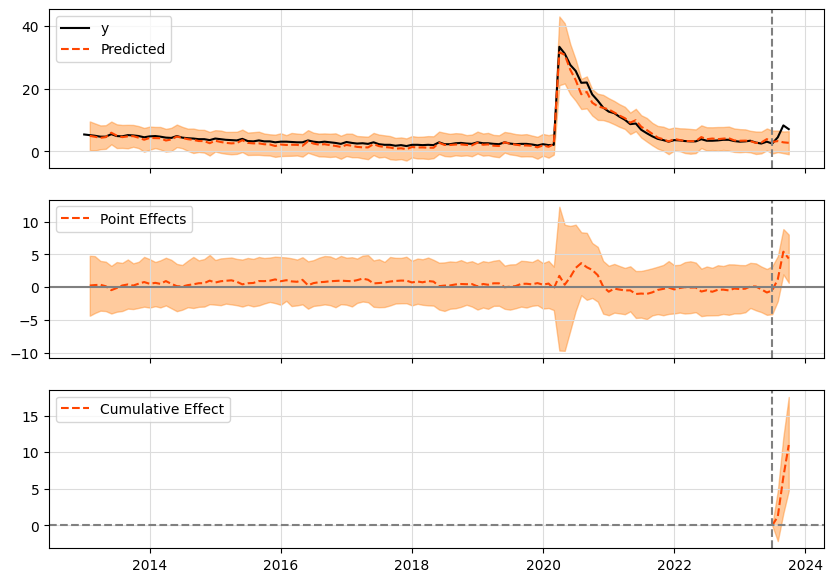

In [15]:
ci.plot()

In [16]:
print(ci.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 6.63. By contrast, in the absence of an
intervention, we would have expected an average response of 2.97.
The 95% interval of this counterfactual prediction is [0.77, 5.18].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 3.66 with a 95% interval of
[1.45, 5.87]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 19.9.
By contrast, had the intervention not taken place, we would have expected
a sum of 8.91. The 95% interval of this prediction is [2.3, 15.54].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an in

# The Effect of ChatGPT on the Interest in AI

In [57]:
df = pd.read_csv('./Data/AI_and_ChatGPT.csv', header=1)
df

,Week,AI: (United States),ChatGPT: (United States)
0,2018-12-09,7,<1
1,2018-12-16,7,0
2,2018-12-23,6,0
3,2018-12-30,5,0
4,2019-01-06,7,0
...,...,...,...
255,2023-10-29,79,42
256,2023-11-05,85,47
257,2023-11-12,84,47
258,2023-11-19,75,35


In [58]:
df = df.rename(columns = {'AI: (United States)':'AI','ChatGPT: (United States)':'ChatGPT'})
df.drop('ChatGPT', axis=1, inplace=True)
df['Week']  = pd.to_datetime(df['Week'])
df

,Week,AI
0,2018-12-09,7
1,2018-12-16,7
2,2018-12-23,6
3,2018-12-30,5
4,2019-01-06,7
...,...,...
255,2023-10-29,79
256,2023-11-05,85
257,2023-11-12,84
258,2023-11-19,75


In [59]:

intervention_date = '2022-11-30'

pre_period_start = min(df['Week'])
pre_period_stop = max(df[df['Week'] < intervention_date]['Week'])

post_period_start = min(df[df['Week'] >= intervention_date]['Week'])
post_period_stop = max(df['Week'])

In [60]:
pre_period=[pre_period_start, pre_period_stop]
post_period=[post_period_start, post_period_stop]

In [61]:
df = df.set_index('Week')

In [63]:
ci = CausalImpact(df[['AI']], pre_period=pre_period, post_period=post_period)

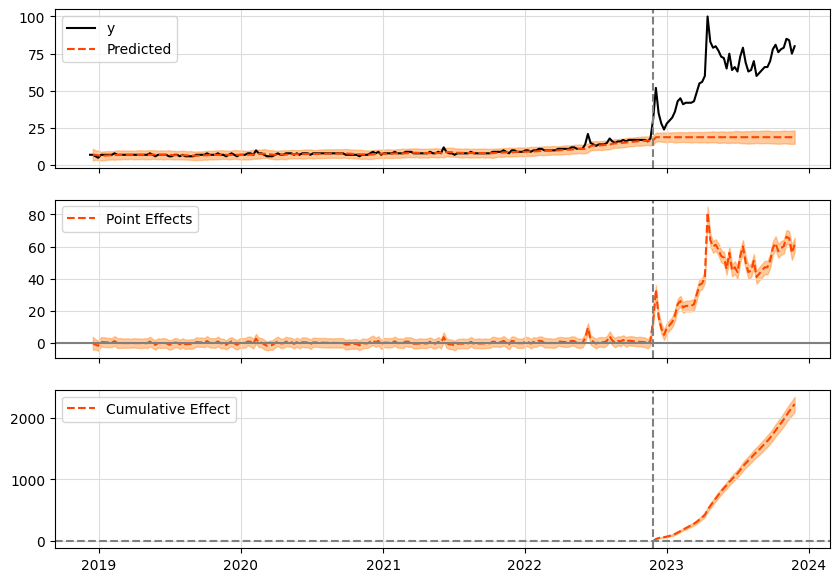

In [64]:
ci.plot()

In [65]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    61.58              3202.0
Prediction (s.d.)         18.83 (1.16)       979.36 (60.33)
95% CI                    [16.7, 21.25]      [868.28, 1104.75]

Absolute effect (s.d.)    42.74 (1.16)       2222.64 (60.33)
95% CI                    [40.33, 44.88]     [2097.25, 2333.72]

Relative effect (s.d.)    226.95% (6.16%)    226.95% (6.16%)
95% CI                    [214.15%, 238.29%] [214.15%, 238.29%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [66]:
print(ci.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 61.58. By contrast, in the absence of an
intervention, we would have expected an average response of 18.83.
The 95% interval of this counterfactual prediction is [16.7, 21.25].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 42.74 with a 95% interval of
[40.33, 44.88]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 3202.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 979.36. The 95% interval of this prediction is [868.28, 1104.75].


The above results are given in terms of absolute numbers. In relative
terms, the response variab